<a href="https://colab.research.google.com/github/ckevar/Conv4MammographyAbnormalities/blob/main/Pre_Trained_2classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries and Mounting Drive
In this notebook, a 2-class classifier is built from a pre-trained model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import os

import requests

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Models to adopt
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from google.colab import output
from google.colab import drive

# Mounting Drive
drive.mount("/content/gdrive")
base_path = "/content/gdrive/My Drive/CI_proj/"
metrics_path = base_path+"metrics/"

Mounted at /content/gdrive


# Loading Data
data for training only

In [ ]:
img = np.load(base_path+'dataset/train_tensor.npy') 
labels = np.load(base_path+'dataset/train_labels.npy') 
depth, width, height = img.shape # shape of the train label depth_val, width_val, height_val = images_val.shape # shape of the train label
classLabel = ["Mass", "Calcification"]

# Pre-processing Data
Since the adopted networks require a 3-channel image. the 1-channel mammography has been extend to 3 by adding the same image in the remaining channels. As same as in the previous binary task classification, the label 0 means mass and the label 1, calcification.

In [ ]:
labels_train = np.array([]);
idx = [];

# Extraction of Mass and Calcificacion from the dataset
for i in range(depth):
  if ((labels[i] == 1) or (labels[i] == 2)):    # mass
    idx.append(i)
    labels_train = np.append(labels_train, [0])

  elif ((labels[i] == 3) or (labels[i] == 4)):  # calcification
    idx.append(i)
    labels_train = np.append(labels_train, [1]);

# Filter the abnormal images    
img2 = img[idx];
depth = idx.__len__()

# Triple the black and white colour to a 3-colour channel 
img = np.zeros((depth, width, height, 3))

for i in range(depth):
  img[i, :, :, 0] = img2[i]
  img[i, :, :, 1] = img2[i]
  img[i, :, :, 2] = img2[i]
  
# Normalization
img = img.astype('float32') / 65535;

# Plot some Sample

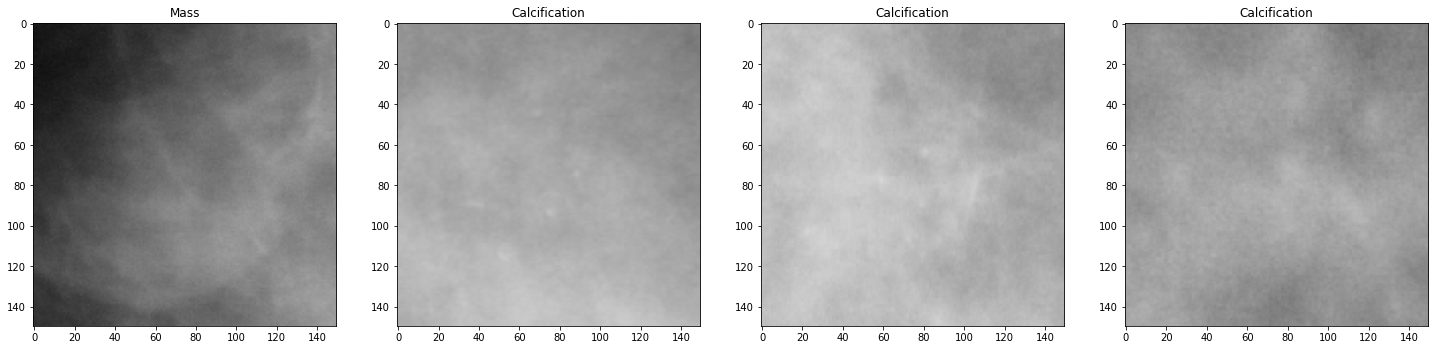

In [ ]:
toPlot = np.random.randint(depth, size = 4)

plt.figure(figsize=(25, 10))
for x in range(toPlot.__len__()):
  plt.subplot(1, 4, x + 1)
  plt.imshow(img[toPlot[x]])
  plt.title(classLabel[np.int_(labels_train[toPlot[x]])])

# Helper Functions

In [ ]:
def reset_weights(md):
  # reset weights and hopelly releases memory and maybe it's depricated, but 
  # here it's just in case an OMM error pops.
  session = backend.get_session()
  for layer in md.layers:
      backend.clear_session()

def loadResultMetrics(fileName):
  # Load metrics from a file
  a = np.load(fileName)
  return a[0], a[1], a[2], a[3]

def BotNotifier(message):
  # function that sends notification over telegram to a bot
    TOKEN = "995731858:AAHrY8FYsa0sE6zKkRGtkZgdLo7-VDjvORo"
    CHAT_ID = "597192342"
    URL = "https://api.telegram.org/bot{}/".format(TOKEN)
    url = URL + "sendMessage?text={}&chat_id={}".format(message, CHAT_ID)
    response = requests.get(url)

def PlotFiles(arg):
  # Plot n = size(arg) metric files
  plt.figure(figsize=(25, 8))

  acc = []
  loss = []
  val_acc = []
  val_loss = []

  for files in arg:
    if files is not None:
      acc, loss, val_acc, val_loss = loadResultMetrics(os.path.join(metrics_path, files))
      plt.subplot(1, 2, 1)
      plt.plot(acc, label = 'Train ' + files)
      plt.plot(val_acc, label = 'Val acc ' + files)
      plt.subplot(1, 2, 2)
      plt.plot(loss, label="Training loss " + files)
      plt.plot(val_loss, label="Val loss " + files)

  plt.subplot(1, 2, 1)
  plt.grid()
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.grid()
  plt.legend()

def runModel_generator_w_KFold(model, img, labels_train, optmz, kFold, epoch, batch_size):
  # Implements k-fold algorithm with augmented data
  depth, _, _, _ = img.shape;
  chunk = depth // kFold

  idx = np.arange(depth);
  np.random.shuffle(idx);

  # Metrics vector
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # generator
  train_datagen = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     )

  valid_datagen = ImageDataGenerator(rescale=1.)
  
  # Model compilation
  model.compile(optimizer = optmz, loss="mse", metrics = ['accuracy'])
  model.save_weights(base_path+'task31_pretrained.h5')

  # Area under validation accuracy
  val_acc_int = 0.0  

  for fold in range(kFold):
    print('START,',fold+1,'/',kFold,'--------------------------------------------------------------------------------')
    
    # k-fold algorithm
    valid = idx[fold * chunk : (fold + 1) * chunk];
    train = np.concatenate((idx[:fold * chunk], idx[(fold + 1) * chunk:]), axis=0)
    
    # generator-flow
    train_generator = train_datagen.flow(img[train], labels_train[train], batch_size=batch_size)
    valid_generator = valid_datagen.flow(img[valid], labels_train[valid])

    model.load_weights(base_path+'task31_pretrained.h5')

    # train
    h = model.fit(train_generator, 
                            steps_per_epoch=np.ceil(train.shape[0]/batch_size), 
                            epochs=epoch, 
                            validation_data=valid_generator, 
                            validation_steps=np.ceil(valid.shape[0]/batch_size), 
                            verbose=0)    
    # log metrics
    val_acc_0 = h.history['val_accuracy'];
    acc.append(h.history['accuracy'])
    loss.append(h.history['loss'])
    val_acc.append(val_acc_0)
    val_loss.append(h.history['val_loss'])

    print('=> acc:',acc[-1][-1], 'loss:',loss[-1][-1], 'val_acc:',val_acc[-1][-1], 'val_loss:',val_loss[-1][-1])
    print('DONE------------------------------------------------------------------------------------------')

    reset_weights(model)

    val_acc_int += np.sum(val_acc_0, axis=0);
    
    print('Area Below Accuracy is ' , val_acc_int / (fold + 1.0))

  # Average metrics  
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)

  return acc, loss, val_acc, val_loss, val_acc_int/5.0

def trainerNtimes_generator_saveInitModel(n_times, starts_in, genModelx, arg, img, labels_train, lr, k, EPOCH, BATCH, saveIt, fileName):
  # Can run the k-fold trainer n_times

  # Metric Vectors
  acc = []
  loss = []
  val_acc = []
  val_loss = []

  # Notifies, a training has started
  BotNotifier("Starting p31 with " + str(arg))

  for x in range(n_times):
    print('[RUNNING@',x,'] with arg',arg)
    backend.clear_session()

    # Creates optimizer and model
    adam = Adam(lr=lr);
    model = genModelx(arg);

    # Train using k-fold with augmented data
    a, b, c, d, aba = runModel_generator_w_KFold(model, img, labels_train, adam, k, EPOCH, BATCH)
    
    # Release memmory
    del model
    del adam

    # log metrics
    acc.append(a)
    loss.append(b)
    val_acc.append(c)
    val_loss.append(d)
    starts_in = starts_in + 1

  # average metrics
  acc = np.average(acc, axis=0)
  loss = np.average(loss, axis=0)
  val_acc = np.average(val_acc, axis=0)
  val_loss = np.average(val_loss, axis=0)

  # save metrics
  if (saveIt): 
    np.save(fileName + ".npy", np.stack((acc, loss, val_acc, val_loss)))

  # report, training has done
  BotNotifier("Done on ckevar with " + str(arg) + " ABA: " + str(aba));
  return acc, loss, val_acc, val_loss

# General Parameters

In [ ]:
k = 5;      # this represents the 20 % of data set provided
EPOCH = 50  # Epochs per training
BATCH = 64  # Size of the batch
learning_rate = 0.0001 # Learning Rate
save_model = True       # variable to enable/disable the saving of generated model
times2run_trainer = 1   # Times the trainer will run on the same (the model restarts between trainings)

#Model with a Flatten Layer
The firt attempt for building a pre-trained classifier, only plugging a dense 1-neuron layer on top of the pre-trained model

In [ ]:
def GeneralPreTrainedModel(arg):
  
  # add new classifier layers
  flat1 = layers.Flatten()(arg.layers[-1].output)
  output = layers.Dense(1, activation='sigmoid')(flat1)

  # define new pre-trained model
  model_return = models.Model(inputs=arg.inputs, outputs=output)

  # summarize the pre-trained model
  model_return.summary()
  return model_return

##VGG16 as Feature Extractor
VGG16 will be only used as feature extractor, initially, then a fine-tune will be performed to adjust the weights of the network

In [ ]:
pre_trained_model = VGG16(include_top=False, input_shape=(width, height, 3)) # VGG16 model

# Set the model as feature extractor
pre_trained_model.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f16c0fb4eb8>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


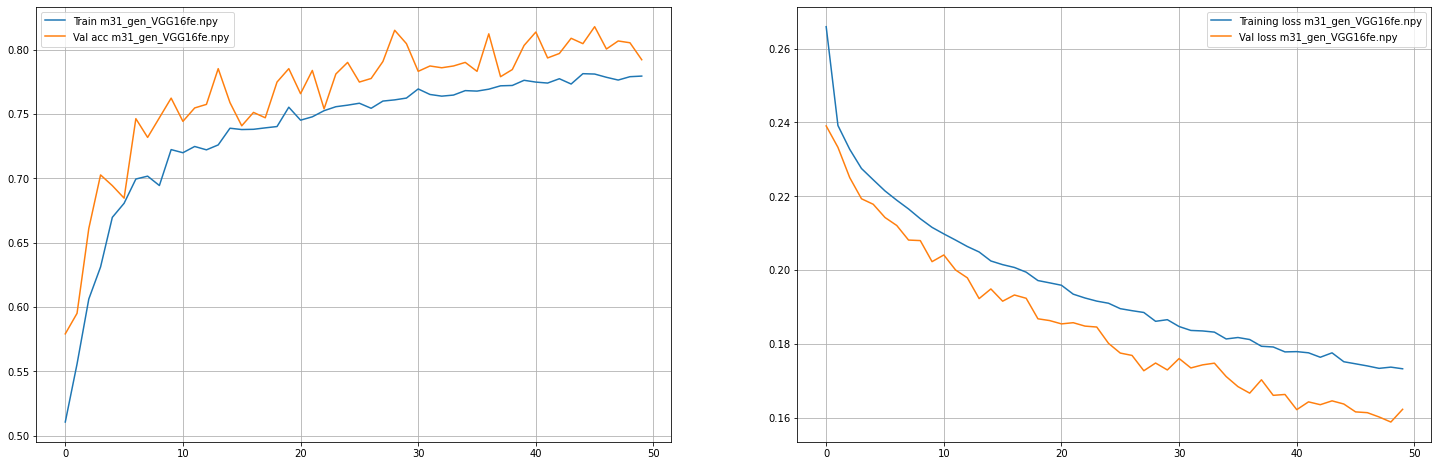

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModel, 
                                      pre_trained_model, img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "m31_gen_VGG16fe"))
PlotFiles(("m31_gen_VGG16fe.npy", None))

###VGG16 Fine Tuning
the trainability of the pre-trained model is enabled, and compared to its learning curves against the feature-extractor-only model.

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f963bcc77f0>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:218: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:221: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:225: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

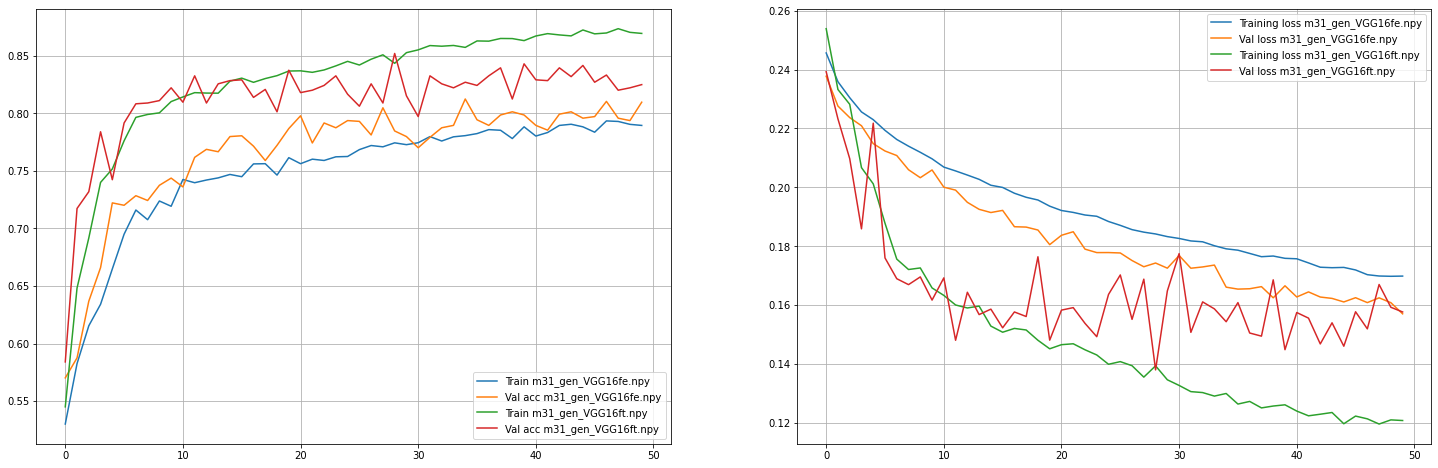

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModel, 
                                      pre_trained_model, img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "m31_gen_VGG16ft"))
PlotFiles(("m31_gen_VGG16fe.npy", "m31_gen_VGG16ft.npy"))

##InceptionV3 as Feature Extractor
Analoguesly, InceptionV3 model is initially trained as feature extractor 

In [ ]:
del pre_trained_model
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 

# Set the model as feature 
pre_trained_model.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f165a099eb8>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


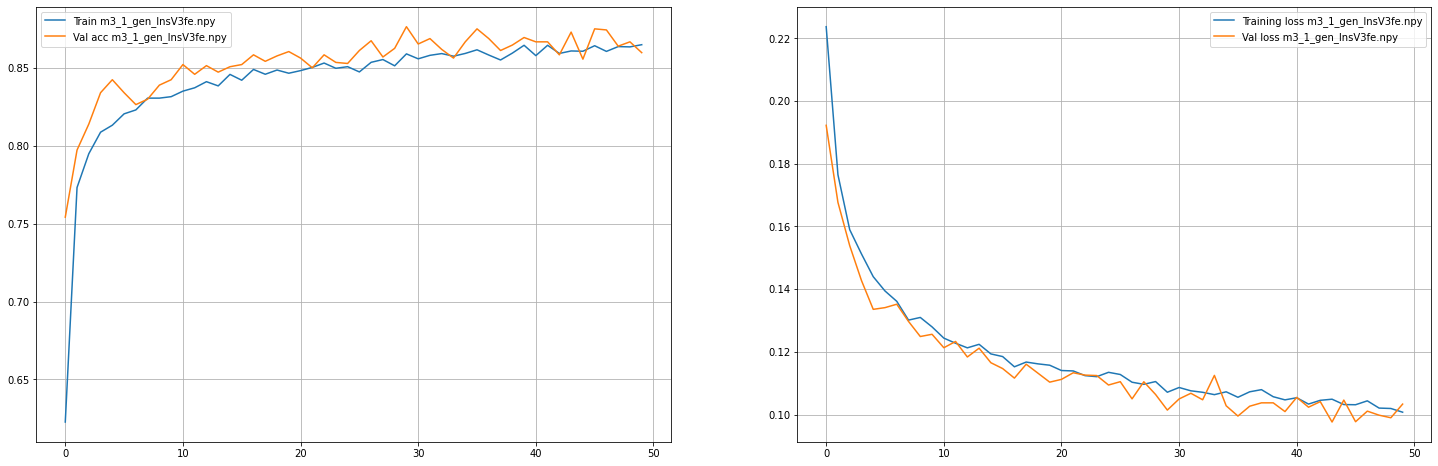

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModel, 
                                      pre_trained_model, img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "m3_1_gen_InsV3fe"))
PlotFiles(("m3_1_gen_InsV3fe.npy", None))

###InceptionV3 Fine Tuning
In this section, the InceptionV3 mode is enabled to trained their own parameters

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f165a099eb8>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

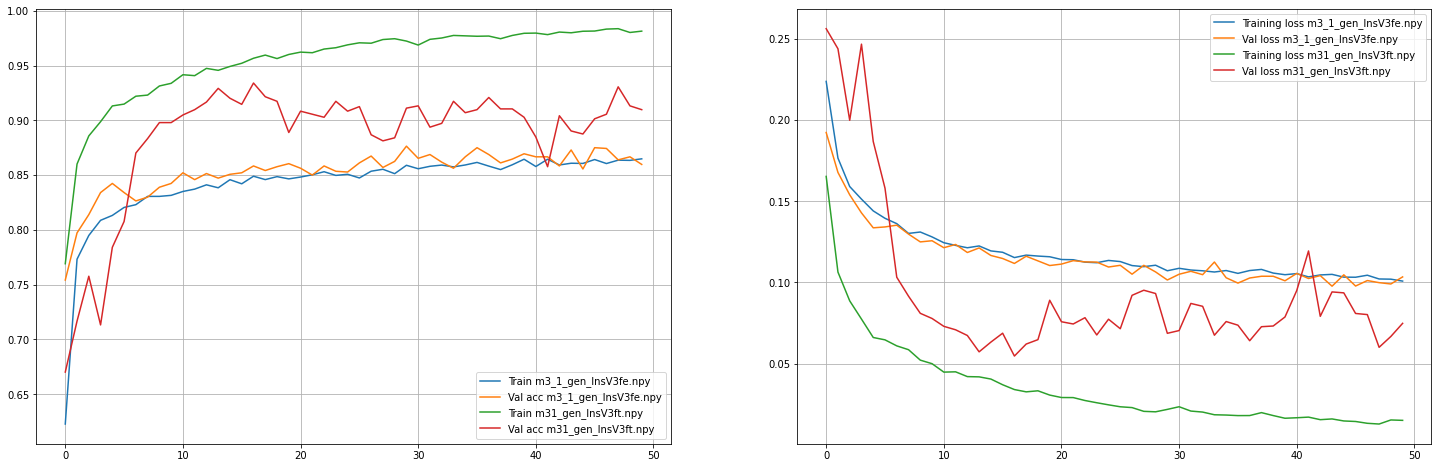

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModel, 
                                      pre_trained_model, img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "m31_gen_InsV3ft"))
PlotFiles(("m3_1_gen_InsV3fe.npy", "m31_gen_InsV3ft.npy"))

#Model With A Dense Layer
It's not that networks performed poorly, but let us see if their performance can get higher. So, this next model incorporates a 2048-neuron layer between the output layer and the pre-trained model

In [ ]:
def GeneralPreTrainedModelDense(arg):
  
  # add new classifier layers
  flat1 = layers.Flatten()(arg.layers[-1].output)
  dense1 = layers.Dense(2048, activation='relu')(flat1)
  # 1 Output
  output = layers.Dense(1, activation='sigmoid')(dense1)

  # define new pre-trained model
  model_return = models.Model(inputs=arg.inputs, outputs=output)

  # summarize the pre-trained model
  model_return.summary()
  return model_return

##VGG16 Feature Extractor
As above, firstly, the model is trained using the pre-trained model as feature extractor only

In [ ]:
# Memory release in case there was another variable with same name
del pre_trained_model
pre_trained_model = VGG16(include_top=False, input_shape=(width, height, 3)) # VGG16 model

# Set the model as feature 
pre_trained_model.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


The pretrained model as feature extractor have a better performance compared to the feature extractor of the flatten VGG16 model

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f8ea0152a58>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

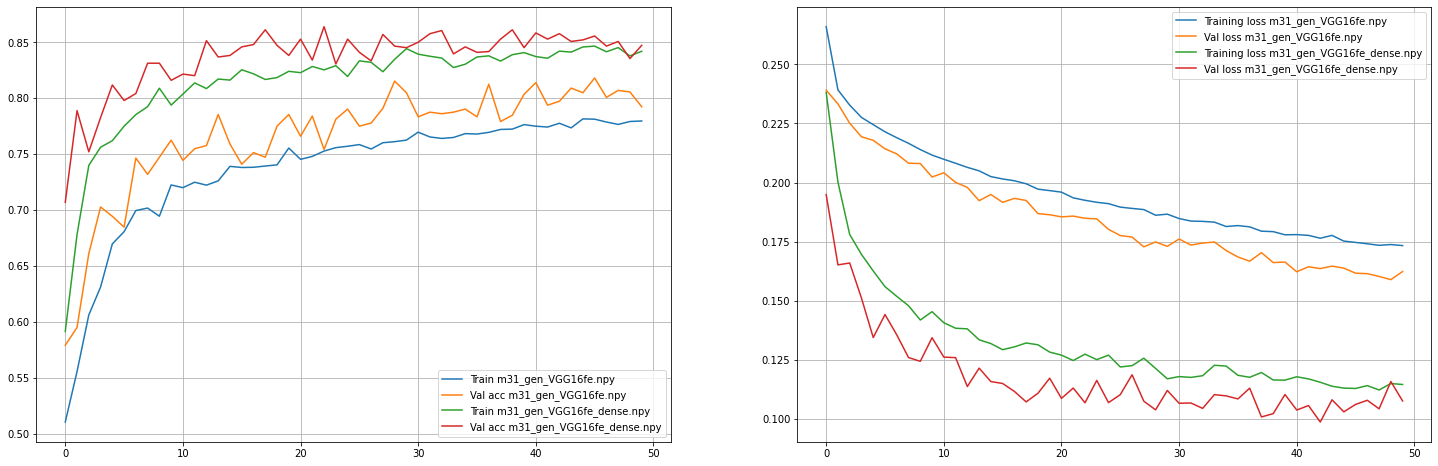

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModelDense,
                                      pre_trained_model, img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m31_gen_VGG16fe_dense"))
PlotFiles(("m31_gen_VGG16fe.npy", "m31_gen_VGG16fe_dense.npy"))

###Fine Tuning
Fine-tuning the VGG16 + dense layer

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f8ea0152a58>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

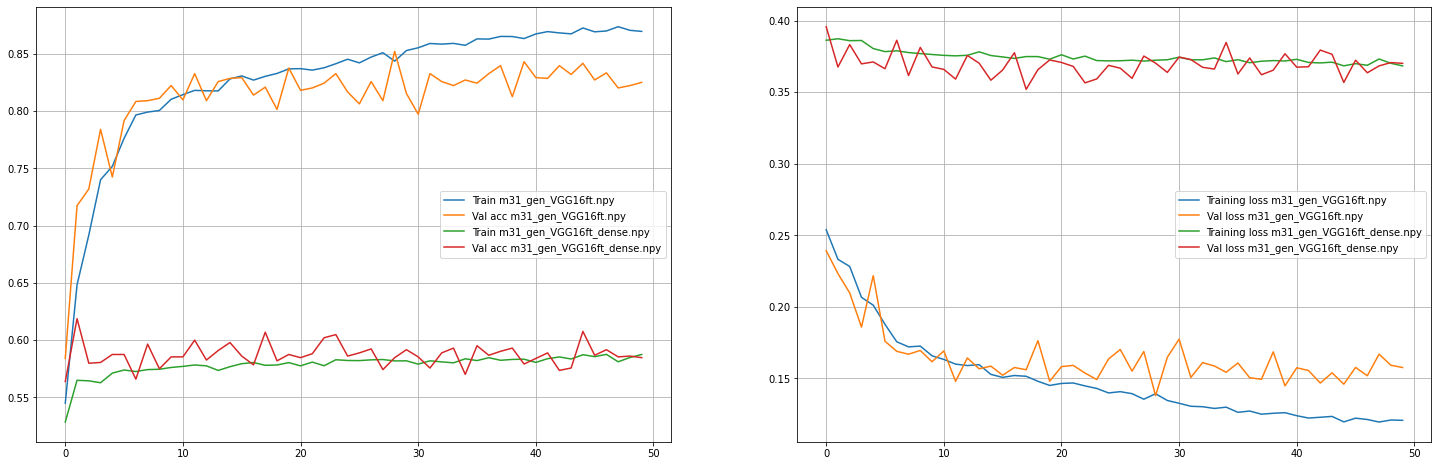

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModelDense,
                                      pre_trained_model, img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, 
                                      os.path.join(metrics_path, "m31_gen_VGG16ft_dense"))
PlotFiles(("m31_gen_VGG16ft.npy", "m31_gen_VGG16ft_dense.npy"))

Fine-tuning did not help increasing the performance of the VGG+dense model

##InceptionV3 Feature Extractor

In this section, the InceptionV3 model is the feature extractor and there's a dense layer between the output layer and the pre-trained model. Firstly, it will be trained as feature extractor

In [ ]:
del pre_trained_model 
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 

# Set the model as feature 
pre_trained_model.trainable = False

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7f8c9f8ccc88>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

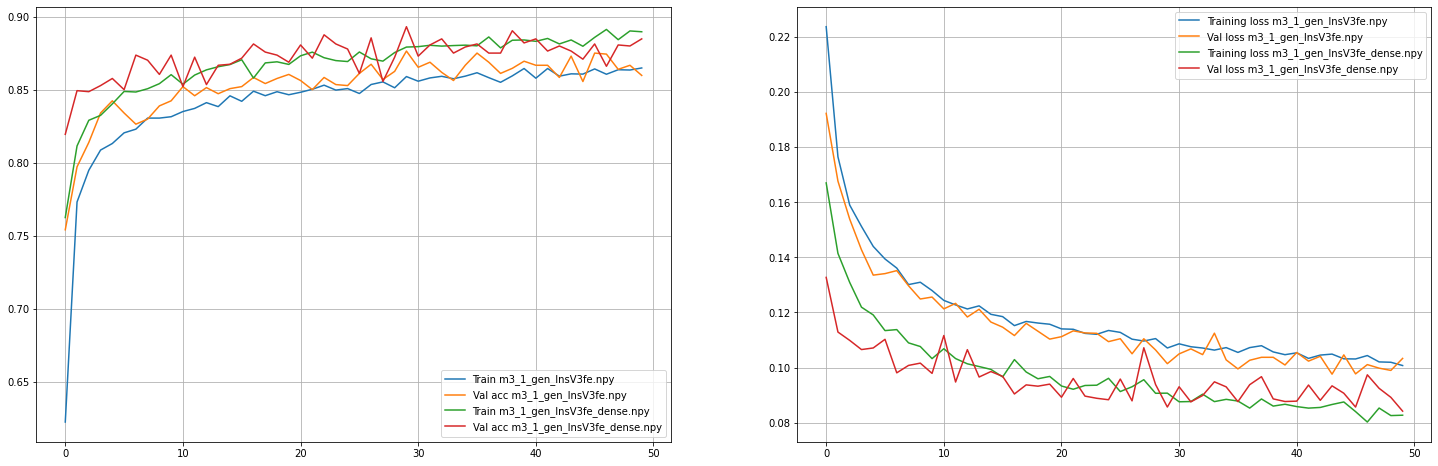

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModelDense, 
                                      pre_trained_model, img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "m3_1_gen_InsV3fe_dense"))
PlotFiles(("m3_1_gen_InsV3fe.npy", "m3_1_gen_InsV3fe_dense.npy"))

One more time the feature extractor works great as feature extractor only

###Fine Tuning

A model that already works great as feature extractor might increase its performance after fine tuning.

[RUNNING@ 0 ] with arg <tensorflow.python.keras.engine.functional.Functional object at 0x7fbdb61a8ba8>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

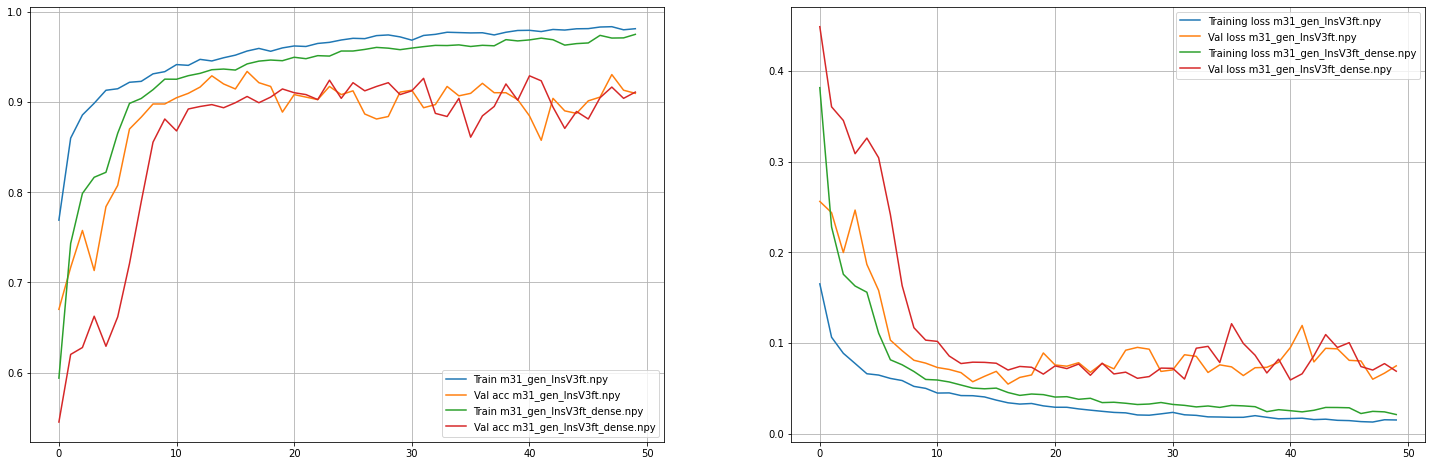

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModelDense, 
                                      pre_trained_model, img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "m31_gen_InsV3ft_dense"))
PlotFiles(("m31_gen_InsV3ft.npy", "m31_gen_InsV3ft_dense.npy"))

No, the IncevptionV3+dense layer did not perform better than the simple flatten inceptionV3.

##Comparing Results
let us compare best models we have so far.

In the VGG16 side, the fine-tuned flatten vs the dense version of it as feature extractor only. 

In the inceptionV3 side: The dese as feature extractor versus the fine-tuned Flatten. 

###VGG16: Feature Extractor with Dense vs Flat Fine Tuning
From the learning curves, it is seen the best of them is the feature extractor with a dense layer before de output.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

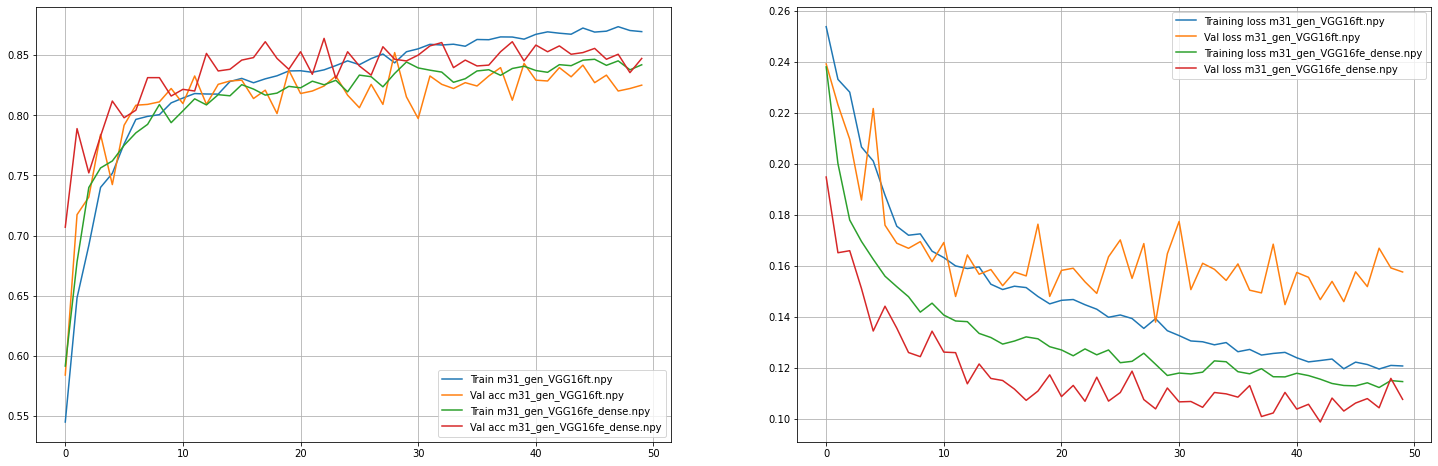

In [ ]:
PlotFiles(("m31_gen_VGG16ft.npy", "m31_gen_VGG16fe_dense.npy"))


### InceptionV3: Feature Extractor with Dense vs Flat Fine Tuning   
In this case, it is undouptly that the fine-tuned model performs best in terms of a accuracy and loss.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

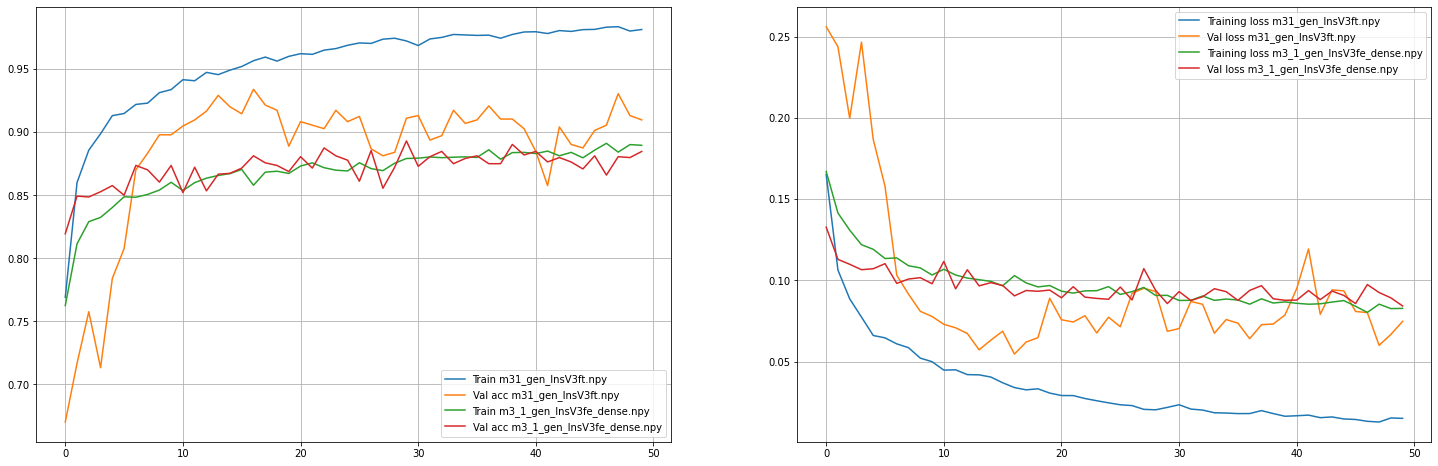

In [ ]:
PlotFiles(("m31_gen_InsV3ft.npy", "m3_1_gen_InsV3fe_dense.npy"))

### Best of InceptionV3 (flat) vs VGG16 (dense)
Comparing the best model of the two pre-trained model submited for evaluation. Once again, the fine-tuned flatten InceptionV3 is the best so far. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

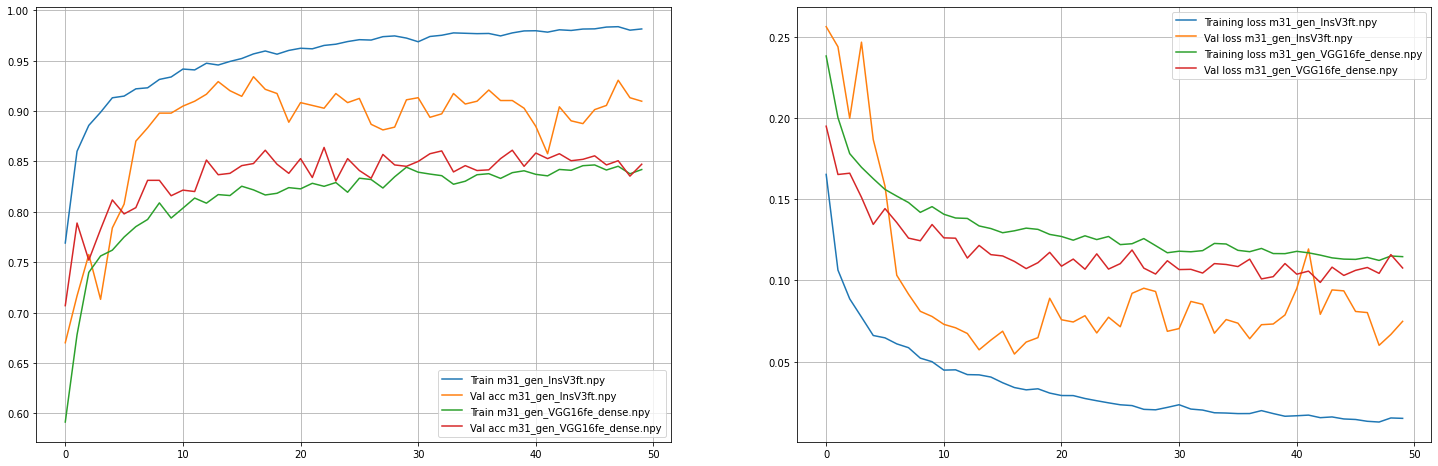

In [ ]:
PlotFiles(("m31_gen_InsV3ft.npy", "m31_gen_VGG16fe_dense.npy"))

#Model with Dropout layer
Since InceptionV3 with the flatten output is the pre-trained model which performs the best, the following experiments will only involve the inceptionV3 model. Observing its learning curve it's clear there exists an over-fitting problem, that's why a dropout layer will placed between the pre-trained model and the output layer with different rates.

In [ ]:
def GeneralPreTrainedModelDropout(arg):
  
  # add new classifier layers
  flat1 = layers.Flatten()(arg[0].layers[-1].output)
  dropout1 = layers.Dropout(arg[1])(flat1)
  # 1 Output
  output = layers.Dense(1, activation='sigmoid')(dropout1)

  # define new pre-trained model
  model_return = models.Model(inputs=arg[0].inputs, outputs=output)

  # summarize the pre-trained model
  model_return.summary()
  return model_return

##InceptionV3 50% Dropout
The first experiment in this approach is the 50% rate, as usual, the pre-trained model will be used as feature only and then it will be fine-tuned.

In [ ]:
del pre_trained_model 
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 

# Set the model as feature 
pre_trained_model.trainable = False

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f8c9e3327f0>, 0.5)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalizatio

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

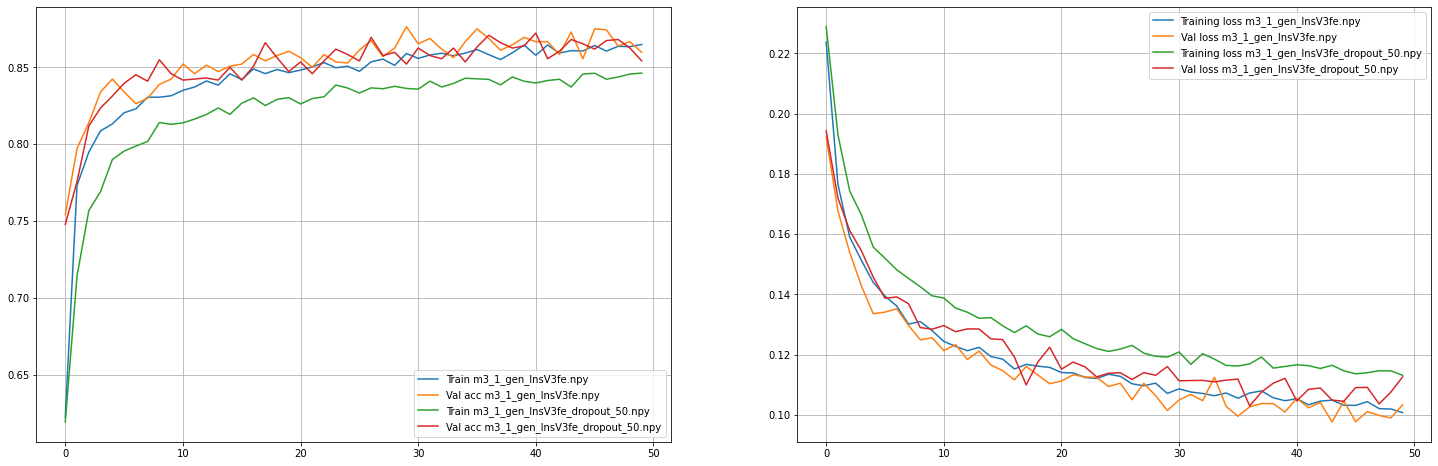

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModelDropout, 
                                      (pre_trained_model, 0.5), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "m3_1_gen_InsV3fe_dropout_50"))
PlotFiles(("m3_1_gen_InsV3fe.npy", "m3_1_gen_InsV3fe_dropout_50.npy"))

From the learning curves, There's not significant difference between their performance. 

###InceptionV3 Fine Tunning
Fine-tuning the 50% droptout rate model

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f8c9e3327f0>, 0.5)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalizatio

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

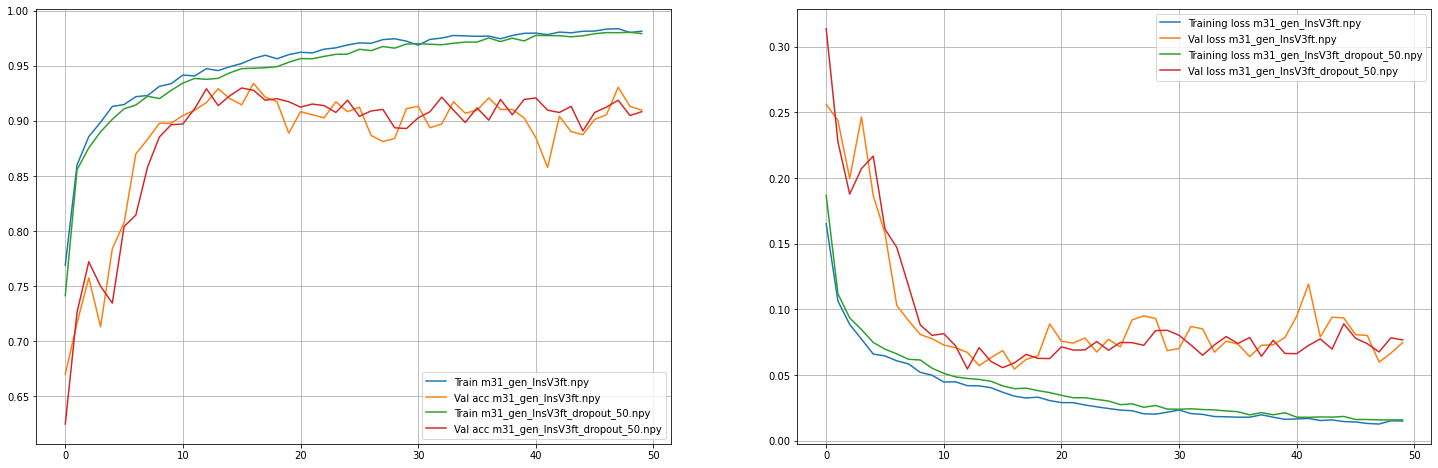

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModelDropout, 
                                      (pre_trained_model, 0.5), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "m31_gen_InsV3ft_dropout_50"))
PlotFiles(("m31_gen_InsV3ft.npy", "m31_gen_InsV3ft_dropout_50.npy"))

Even after fine tuning, there is no remarkable difference between the models, of course the the fine-tuned 50-rate model performs better than the feature extractor model.

##InceptionV3 25% Dropout
If 50% dropout is too much random, let's see if a smaller dropout makes some difference. The following experiment uses 25% of dropping-out rate. As the previous experiments, the pre-trained model is first used as feature extractor only then, it's fine-tuned.

In [ ]:
del pre_trained_model 
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 

# Set the model as feature 
pre_trained_model.trainable = False

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f8c9cf1ccf8>, 0.25)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalizati

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

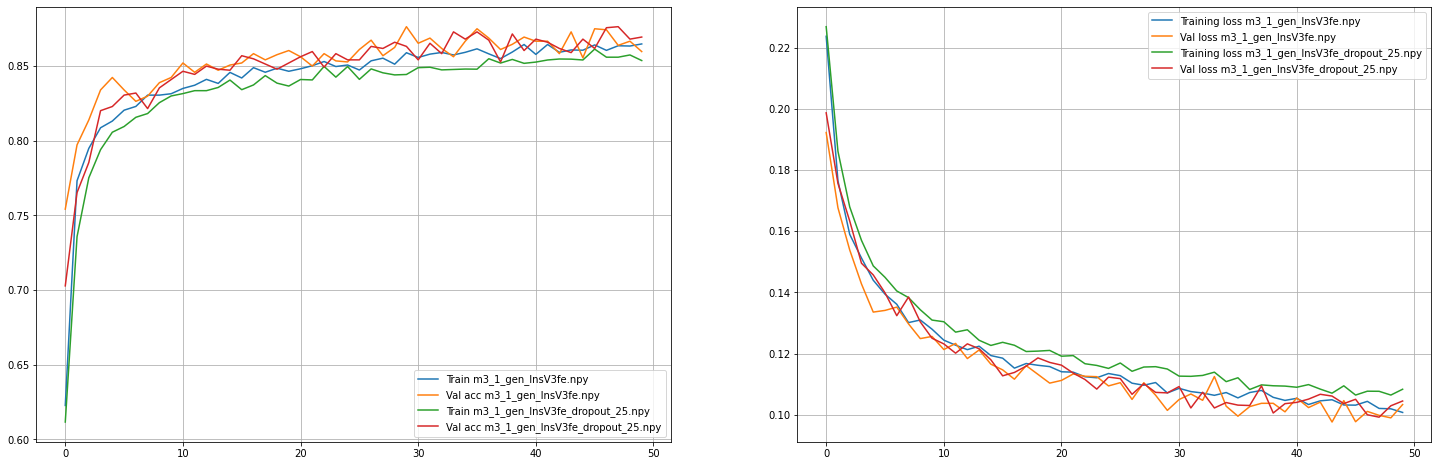

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModelDropout, 
                                      (pre_trained_model, 0.25), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "m3_1_gen_InsV3fe_dropout_25"))
PlotFiles(("m3_1_gen_InsV3fe.npy", "m3_1_gen_InsV3fe_dropout_25.npy"))

From the this stage of learning, nothing is conclusive yet.

###InceptionV3 Fine Tuning
Fine tuning the 25%-rate drop model

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f8c9cf1ccf8>, 0.25)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalizati

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

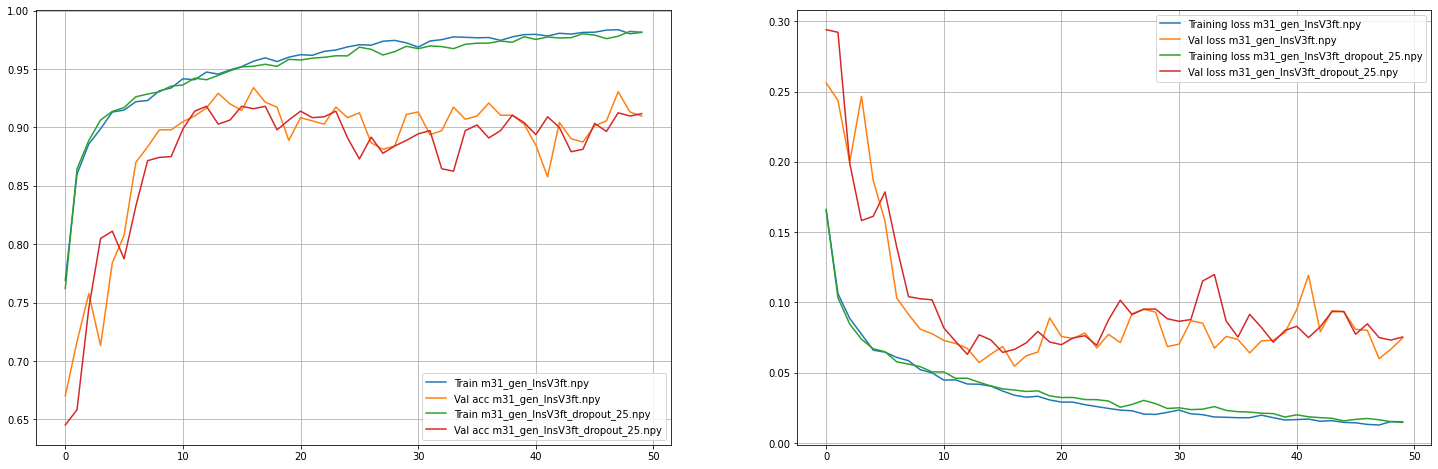

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModelDropout, 
                                      (pre_trained_model, 0.25), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "m31_gen_InsV3ft_dropout_25"))
PlotFiles(("m31_gen_InsV3ft.npy", "m31_gen_InsV3ft_dropout_25.npy"))

This curves tells more about the 25% dropping model, it clearly aggravets the model's performance.

##InceptionV3 80% dropout
Since, 50% doesnt do anything and particular with the performance, 25% gets poor performance from the InceptionV3 model, the a high dropout might get better values. As usual, the pre-trained model first is used as feature extractor then it's fine-tuned.

In [ ]:
del pre_trained_model 
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 

# Set the model as feature 
pre_trained_model.trainable = False

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f8c9e38dac8>, 0.8)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalizatio

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

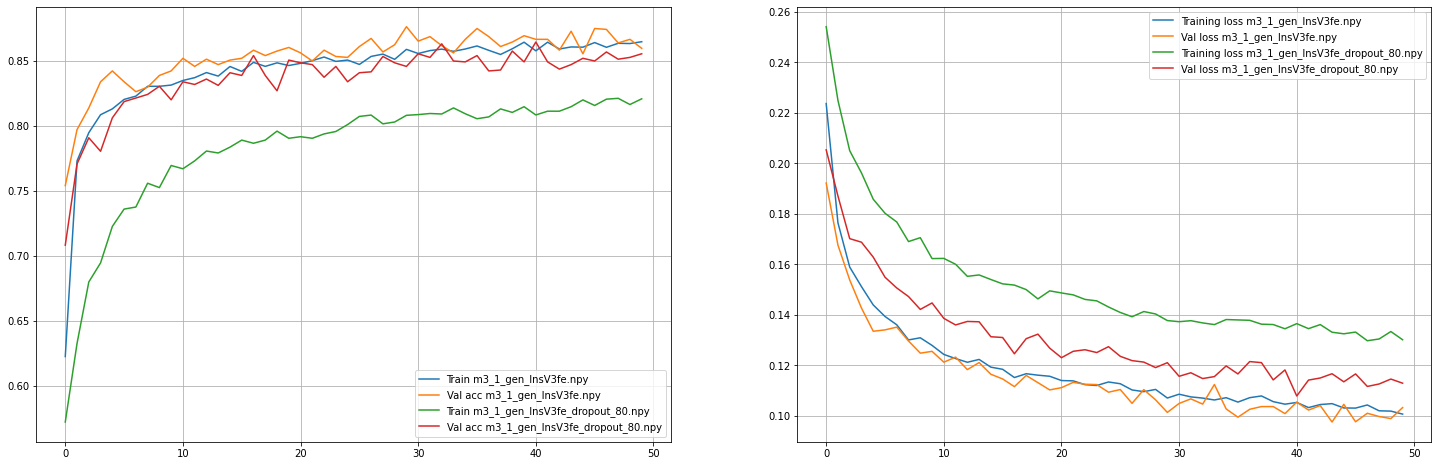

In [ ]:
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModelDropout, 
                                      (pre_trained_model, 0.80), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "m3_1_gen_InsV3fe_dropout_80"))
PlotFiles(("m3_1_gen_InsV3fe.npy", "m3_1_gen_InsV3fe_dropout_80.npy"))

###InceptionV3 Fine Tuning

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7f8c9e38dac8>, 0.8)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalizatio

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

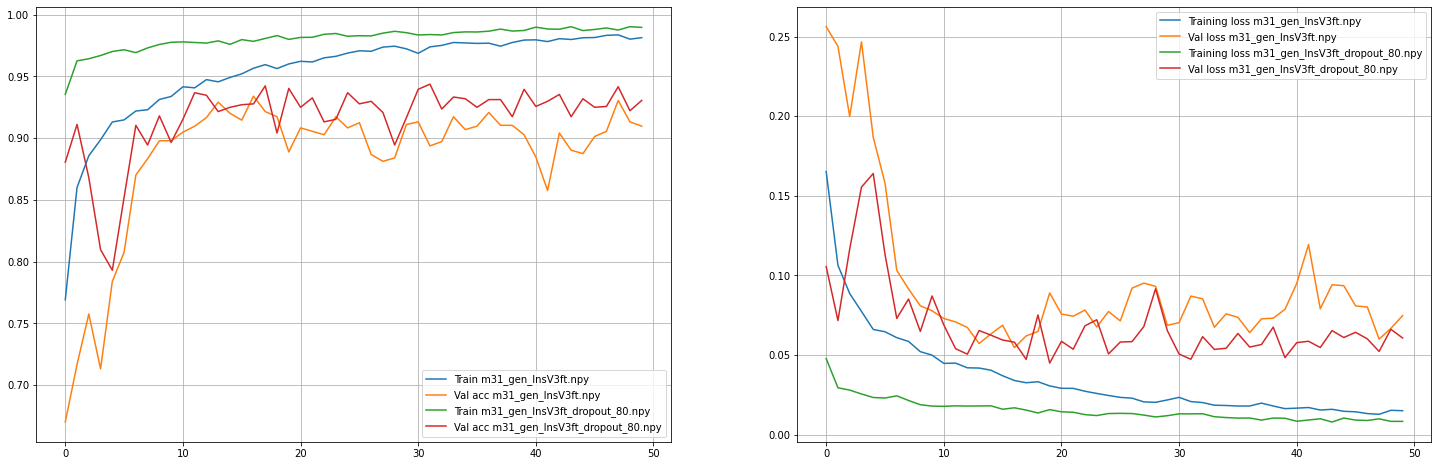

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_saveInitModel(times2run_trainer, 0, GeneralPreTrainedModelDropout, 
                                      (pre_trained_model, 0.80), img, labels_train, learning_rate, 
                                      k, EPOCH, BATCH, save_model, os.path.join(metrics_path, "m31_gen_InsV3ft_dropout_80"))
PlotFiles(("m31_gen_InsV3ft.npy", "m31_gen_InsV3ft_dropout_80.npy"))

dropping 80% of neurons in the last layer of the InceptionV3 increases its performance by around 1%and the loss at validation is also less than the flatten one, however the over-fitting is still present.

##Result Comparison

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

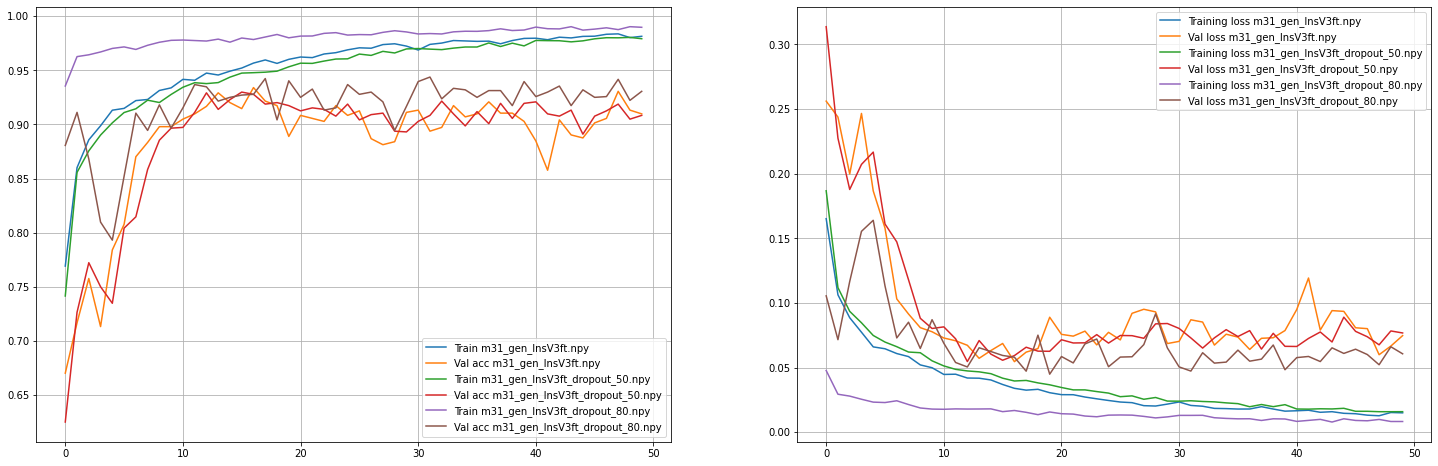

In [ ]:
PlotFiles(("m31_gen_InsV3ft.npy", "m31_gen_InsV3ft_dropout_50.npy", "m31_gen_InsV3ft_dropout_80.npy"))


#Ultimate Training
the IncetionV3 model with dropout of 80% will be adopted as pre-trained classifier for Mass/Calcification. First, the validation Confusion Matrix will be computed, those parameters will be useful for the Ensemble Network 

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def trainModel_w_kFold_n_aug_confusion_mm(model, img, labels_train, optmz, kFold, epoch, batch_size):
  # Implements k-fold
  depth, _, _, _ = img.shape;
  chunk = depth // kFold

  idx = np.arange(depth);
  np.random.shuffle(idx);
  
  # Generator
  train_datagen = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True)
  
  # Model
  model.compile(optimizer = optmz, loss="mse")
  model.save_weights(base_path+'task31_scratch_gen_cm.h5')

  # Metrics
  val_acc = 0.0  
  cmm = np.zeros([2, 2])

  for fold in range(kFold):
    print('START,',fold+1,'/',kFold,'--------------------------------------------------------------------------------')
    
    # k-fold
    valid = idx[fold * chunk : (fold + 1) * chunk];
    train = np.concatenate((idx[:fold * chunk], idx[(fold + 1) * chunk:]), axis=0)
    
    # Generator
    train_generator = train_datagen.flow(img[train], labels_train[train], batch_size=batch_size)

    model.load_weights(base_path+'task31_scratch_gen_cm.h5')

    # train 1-fold
    model.fit(train_generator, steps_per_epoch=np.ceil(train.shape[0]/batch_size), 
              epochs=epoch, verbose=0)
    
    # Validation Confusion Matrix
    aux = model.predict(img[valid])
    y_pred = np.zeros(aux.shape)
    y_pred[aux >= 0.5] = 1
    cmm = cmm + confusion_matrix(labels_train[valid], y_pred, [0, 1])
    val_acc = val_acc + accuracy_score(labels_train[valid], y_pred)

    print('=> val acc:', accuracy_score(labels_train[valid], y_pred))
    print('DONE------------------------------------------------------------------------------------------')

    reset_weights(model)

  cmm_norm = np.sum(cmm)
  
  print("Overall val_acc: ", val_acc / (1.*kFold))
  
  return cmm/cmm_norm, val_acc / (1.*kFold)

def trainerNtimes_generator_confusion_mm(n_times, genModelx, arg, img, labels_train, lr, k, EPOCH, BATCH, saveIt, fileName):
  # Runs n_times the k-fold algorithm
  cmm = []
  val_acc = []

  # Notifies, a training has started
  BotNotifier("Starting pretrained_31 with " + str(arg))

  for x in range(n_times):
    print('[RUNNING@',x,'] with arg',arg)
    backend.clear_session()

    # model creation
    adam = Adam(lr=lr);
    model = genModelx(arg);
    
    # calls k-fold algorithm
    a, b = trainModel_w_kFold_n_aug_confusion_mm(model, img, labels_train, adam, k, EPOCH, BATCH)
    
    # release memory
    del model
    del adam

    # log metrics
    cmm.append(a)
    val_acc.append(b)

  # average metrics
  cmm = np.average(cmm, axis=0)
  val_acc = np.average(val_acc, axis=0)

  # save metrics
  if (saveIt): 
    np.save(fileName, np.stack(cmm))

  # notifies training is over
  BotNotifier("Done on pretrained31 with " + str(arg))

  return cmm, val_acc


def plot_confusion_matrix(cm, num_classes, labels, title='Confusion matrix', cmap=plt.cm.Greys):
  # plots n = size(cm) confusion matrix in nx2 subplots
  rows = np.ceil(len(cm)/2)
  cm_idx = 1
  cols = 2

  plt.figure(figsize=(15, rows*6))

  for files in cm:
    if files is not None:
      cm_i = np.load(os.path.join(metrics_path, files))
      plt.subplot(rows, cols, cm_idx)
      plt.imshow(cm_i, interpolation='nearest', cmap=cmap)
      plt.title(files)
      plt.colorbar()
      tick_marks = np.arange(num_classes)
      plt.xticks(tick_marks, labels)
      plt.yticks(tick_marks, labels)
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      print(files)
      print("=>", cm_i, "\n")

      cm_idx += 1

  plt.show() 

**Control Confusion Matrix** the perfect classifier should a the same control matrix as the training data itself, this validation confusion matrix will allows to compared the performances of the chosen model.

scratch21_control_cm.npy
=> [[0.45515695 0.        ]
 [0.         0.54484305]] 



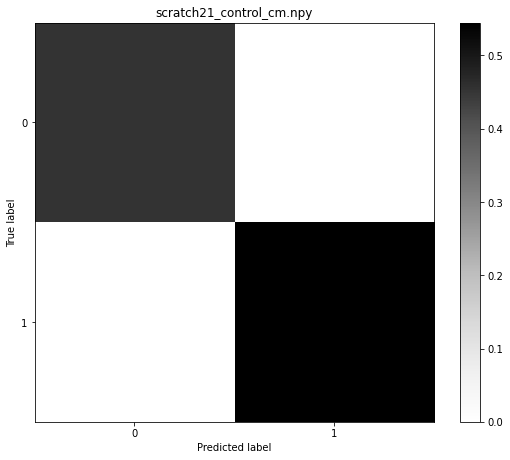

In [ ]:
plot_confusion_matrix(("scratch21_control_cm.npy", None), 2, [0, 1])

Computing Model confusion matrix

In [ ]:
del pre_trained_model

In [ ]:
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 
ULTIMATE_EPOCH = 19

In [ ]:
pre_trained_model.trainable = False
trainerNtimes_generator_confusion_mm(times2run_trainer, GeneralPreTrainedModelDropout, 
                                     (pre_trained_model, 0.8), img, labels_train, 
                                     learning_rate, k, 50, BATCH, save_model, 
                                     os.path.join(metrics_path, "dump_file"))

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7fdccba59400>, 0.8)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalizatio

(array([[0.38803738, 0.06691589],
        [0.07588785, 0.46915888]]), 0.857196261682243)

In [ ]:
pre_trained_model.trainable = True
trainerNtimes_generator_confusion_mm(times2run_trainer, GeneralPreTrainedModelDropout, 
                                     (pre_trained_model, 0.8), img, labels_train, 
                                     learning_rate, k, ULTIMATE_EPOCH, BATCH, 
                                      save_model, os.path.join(metrics_path, "task31_dropout_80_InceptionV3_ft_cm"))
del pre_trained_model

[RUNNING@ 0 ] with arg (<tensorflow.python.keras.engine.functional.Functional object at 0x7fdccba59400>, 0.8)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalizatio

scratch21_control_cm.npy
=> [[0.45515695 0.        ]
 [0.         0.54484305]] 

task31_dropout_80_InceptionV3_ft_cm.npy
=> [[0.39065421 0.0646729 ]
 [0.02915888 0.51551402]] 



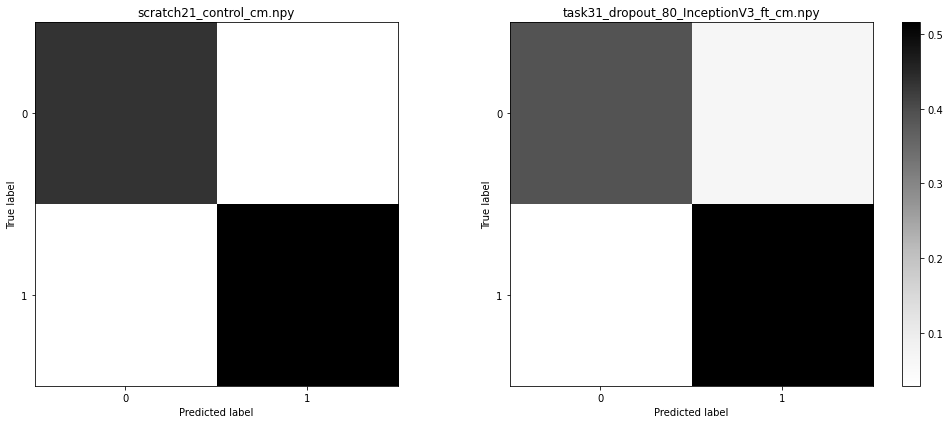

In [ ]:
plot_confusion_matrix(("scratch21_control_cm.npy", "task31_dropout_80_InceptionV3_ft_cm.npy"), 2, [0, 1])

##Training 

In [ ]:
def train_only(modelFoo, arg, lr, img, labels_train, epoch, batch_size, model_name):
  model = modelFoo(arg)
  adam = Adam(lr=lr)
  model.compile(optimizer=adam, loss='mse')

  # Generator
  train_datagen = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True)
  train_generator = train_datagen.flow(img, labels_train, batch_size=batch_size)

  # Train
  model.fit(train_generator, steps_per_epoch=np.ceil(labels_train.shape[0]/batch_size), 
              epochs=epoch, verbose=1)
  # Save Model
  print('Model Save at:', base_path+model_name)
  model.save(base_path+model_name)

def loadModel_fromFile(model2load):
  return models.load_model(base_path+model2load)

two-stages training

In [ ]:
#del pre_trained_model 
pre_trained_model = InceptionV3(include_top=False, input_shape=(width, height, 3)) 
pre_trained_model.trainable = False

# Feature extrator training 
train_only(GeneralPreTrainedModelDropout, (pre_trained_model, 0.8), learning_rate, img, labels_train, 50, BATCH, "task31_fe_model.h5")
# Release memory
del pre_trained_model

# Fine Tune
train_only(loadModel_fromFile, "task31_fe_model.h5", learning_rate, img, labels_train, ULTIMATE_EPOCH, BATCH, "task31_ft_model.h5")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

#Test

##Loading Data

In [ ]:
img_test = np.load(base_path+'dataset/public_test_tensor.npy') 
labels = np.load(base_path+'dataset/public_test_labels.npy') 
depth_test, width_test, height_test = img_test.shape 

Preprocessing

In [ ]:
labels_test = np.array([]);
idx = [];

# Extraction of Mass and Calcificacion from the dataset
for i in range(depth_test):
  if ((labels[i] == 1) or (labels[i] == 2)):    # mass
    idx.append(i)
    labels_test = np.append(labels_test, [0])

  elif ((labels[i] == 3) or (labels[i] == 4)):  # calcification
    idx.append(i)
    labels_test = np.append(labels_test, [1]);

# Filter the abnormal images    
img2_test = img_test[idx];
depth_test = idx.__len__()

# Triple the black and white colour to a 3-colour channel 
img_test = np.zeros((depth_test, width_test, height_test, 3))

for i in range(depth_test):
  img_test[i, :, :, 0] = img2_test[i]
  img_test[i, :, :, 1] = img2_test[i]
  img_test[i, :, :, 2] = img2_test[i]
  
# Normalization
img_test = img_test.astype('float32') / 65535;

##Model Under Test

In [ ]:
mut = models.load_model(base_path+'models/task31_ft_model.h5')

In [ ]:
# Test prediction
aux = mut.predict(img_test)
y_test = np.zeros(aux.shape)
y_test[aux >= 0.5] = 1

# Test Confusion Matrix
cmm = confusion_matrix(labels_test, y_test)
cmm = cmm/np.sum(cmm)
# Save Test confusion matrix
np.save(os.path.join(metrics_path, "task31_test_cm.npy"), np.stack(cmm))

# Release Memory
del mut

# Save y_test for task5: ensemble network
np.save(os.path.join(metrics_path, "task31_y_test_output_label.npy"), np.stack(aux))
print("ACCURACY TEST: ", accuracy_score(labels_test, y_test))

ACCURACY TEST:  0.8452380952380952


Comparing the perfect classifier test confusion matrix as control versus the confusion matrix computed from the predicted test set.

scratch21_test_control_cm.npy
=> [[0.5327381 0.       ]
 [0.        0.4672619]] 

task31_test_cm.npy
=> [[0.44940476 0.08333333]
 [0.07142857 0.39583333]] 



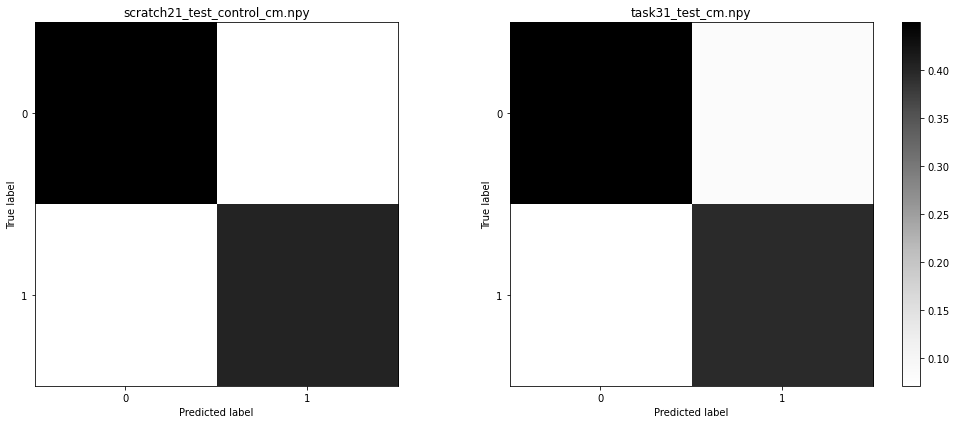

In [ ]:
plot_confusion_matrix(("scratch21_test_control_cm.npy", "task31_test_cm.npy"), 2, [0, 1])